# Importing OSM data from osmnx

See the accompanying discussion in the [guide](https://cityseer.benchmarkurbanism.com/guide).


`matplotlib` magic command (only necessary for `jupyter` notebooks).

Install and update `cityseer` if necessary.


In [1]:
# !pip install --upgrade cityseer
# !pip install osmnx

## Setup

If you're prepared to get your hands dirty, it is possible to directly query the [OSM API](https://wiki.openstreetmap.org/wiki/API) and to then use this data to create a `cityseer` graph. This can be preferred in situations where you want detailed control over the structure of the OSM API query. However, if you prefer, `OSM` data can also be retrieved with [`OSMnx`](https://osmnx.readthedocs.io/) and then converted into a `cityseer` compatible `networkX` graph.

The following example makes use of data for London Soho.


In [1]:
from cityseer import tools
import osmnx as ox
from shapely import geometry
import utm

# centre-point
lng, lat = -0.13396079424572427, 51.51371088849723

# select extents for plotting
easting, northing = utm.from_latlon(lat, lng)[:2]
buff = geometry.Point(easting, northing).buffer(1000)
min_x, min_y, max_x, max_y = buff.bounds

# reusable plot function
def simple_plot(_G):
    # plot using the selected extents
    tools.plot.plot_nx(
        _G,
        labels=False,
        plot_geoms=True,
        node_size=15,
        edge_width=2,
        x_lim=(min_x, max_x),
        y_lim=(min_y, max_y),
        figsize=(10, 10),
        dpi=200,
    )


# Let's use OSMnx to fetch an OSM graph
# We'll use the same raw network for both workflows (hence simplify=False)
multi_di_graph_raw = ox.graph_from_point((lat, lng), dist=1250, simplify=False)

/Users/gareth/dev/benchmark-urbanism/cityseer-api/__pypackages__/3.9/lib/geopandas/_compat.py:112: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


<Figure size 432x288 with 0 Axes>

## Workflow 1

One option is to both download and simplify the data in `OSMnx` and to then convert the graph from `OSMnx` to `cityseer` (per the `tools.graphs.nx_from_osm_nx` method).


INFO:cityseer.tools.graphs:Converting OSMnx MultiDiGraph to cityseer MultiGraph.
100%|██████████| 5376/5376 [00:04<00:00, 1120.42it/s]


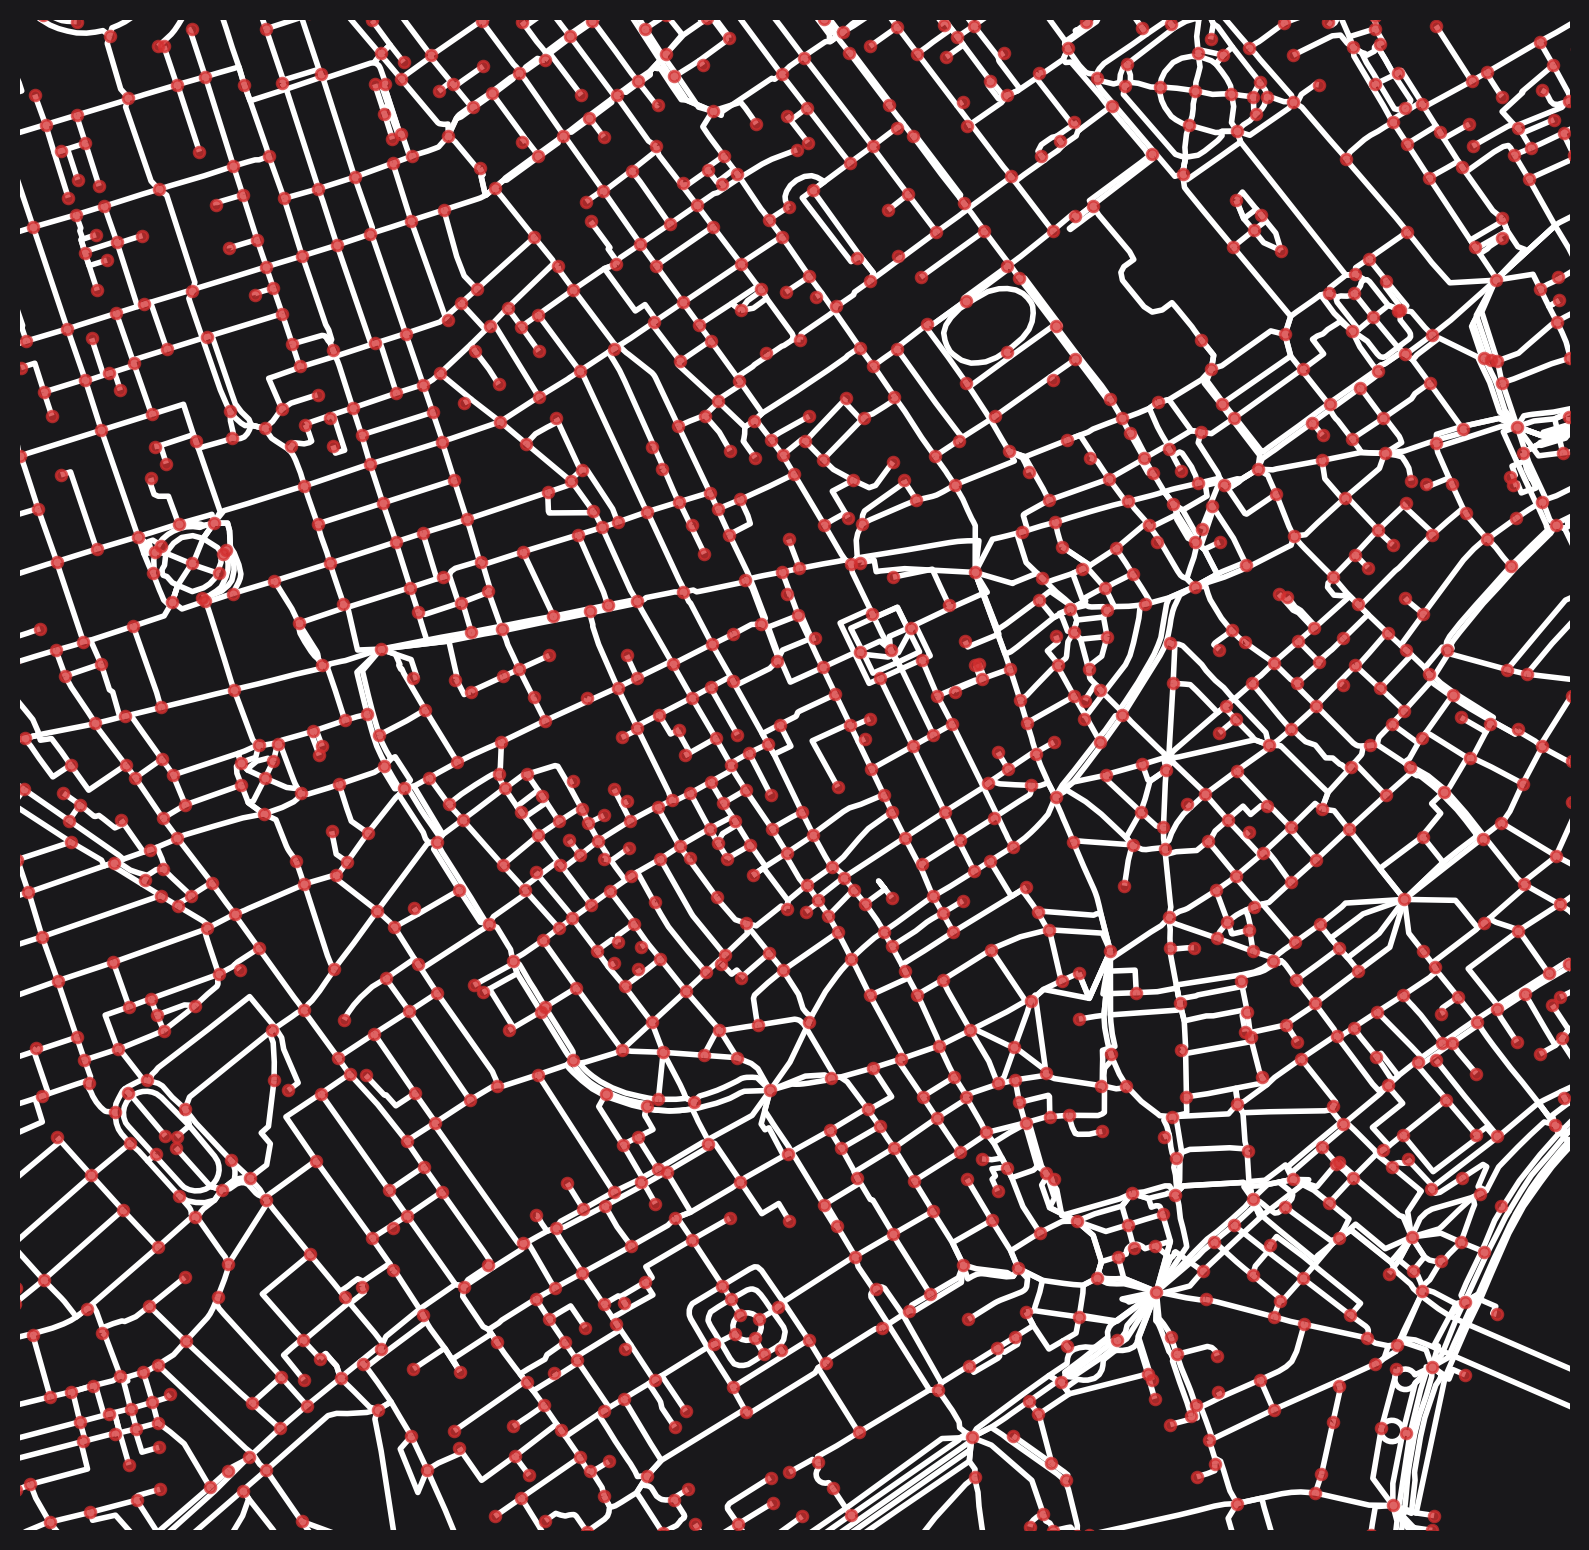

In [3]:
# Workflow 1: Using OSMnx to prepare the graph
# ============================================
# explicit simplification and consolidation via OSMnx
multi_di_graph_utm = ox.project_graph(multi_di_graph_raw)
multi_di_graph_simpl = ox.simplify_graph(multi_di_graph_utm)
multi_di_graph_cons = ox.consolidate_intersections(multi_di_graph_simpl, tolerance=10, dead_ends=True)
# let's use the same plotting function for both scenarios to aid visual comparisons
multi_graph_cons = tools.graphs.nx_from_osm_nx(multi_di_graph_cons, tolerance=50)
simple_plot(multi_graph_cons)

## Workflow 2

Another option is to immediately convert the `osmnx` graph to `cityseer` before downstream processing. This is preferable because it is then easier for `cityseer` to retain the integrity of the roadway geometries while enforcing node coordinate validation for intersections.


INFO:cityseer.tools.graphs:Converting OSMnx MultiDiGraph to cityseer MultiGraph.
100%|██████████| 27406/27406 [00:17<00:00, 1537.30it/s]
INFO:cityseer.tools.graphs:Converting networkX graph from WGS to UTM.
INFO:cityseer.tools.graphs:Processing node x, y coordinates.
100%|██████████| 14348/14348 [00:02<00:00, 6939.36it/s]
INFO:cityseer.tools.graphs:UTM conversion info: UTM zone number: 30, UTM zone letter: U
INFO:cityseer.tools.graphs:Processing edge geom coordinates, if present.
100%|██████████| 16362/16362 [00:08<00:00, 1965.03it/s]
INFO:cityseer.tools.graphs:Generating simple (straight) edge geometries.
100%|██████████| 16362/16362 [00:00<00:00, 39862.01it/s]
INFO:cityseer.tools.graphs:Removing filler nodes.
100%|██████████| 14348/14348 [00:05<00:00, 2784.80it/s]
INFO:cityseer.tools.graphs:Removing dangling nodes.
100%|██████████| 4739/4739 [00:00<00:00, 104234.59it/s]
INFO:cityseer.tools.graphs:Removing filler nodes.
100%|██████████| 4373/4373 [00:00<00:00, 27038.21it/s]
INFO:citys

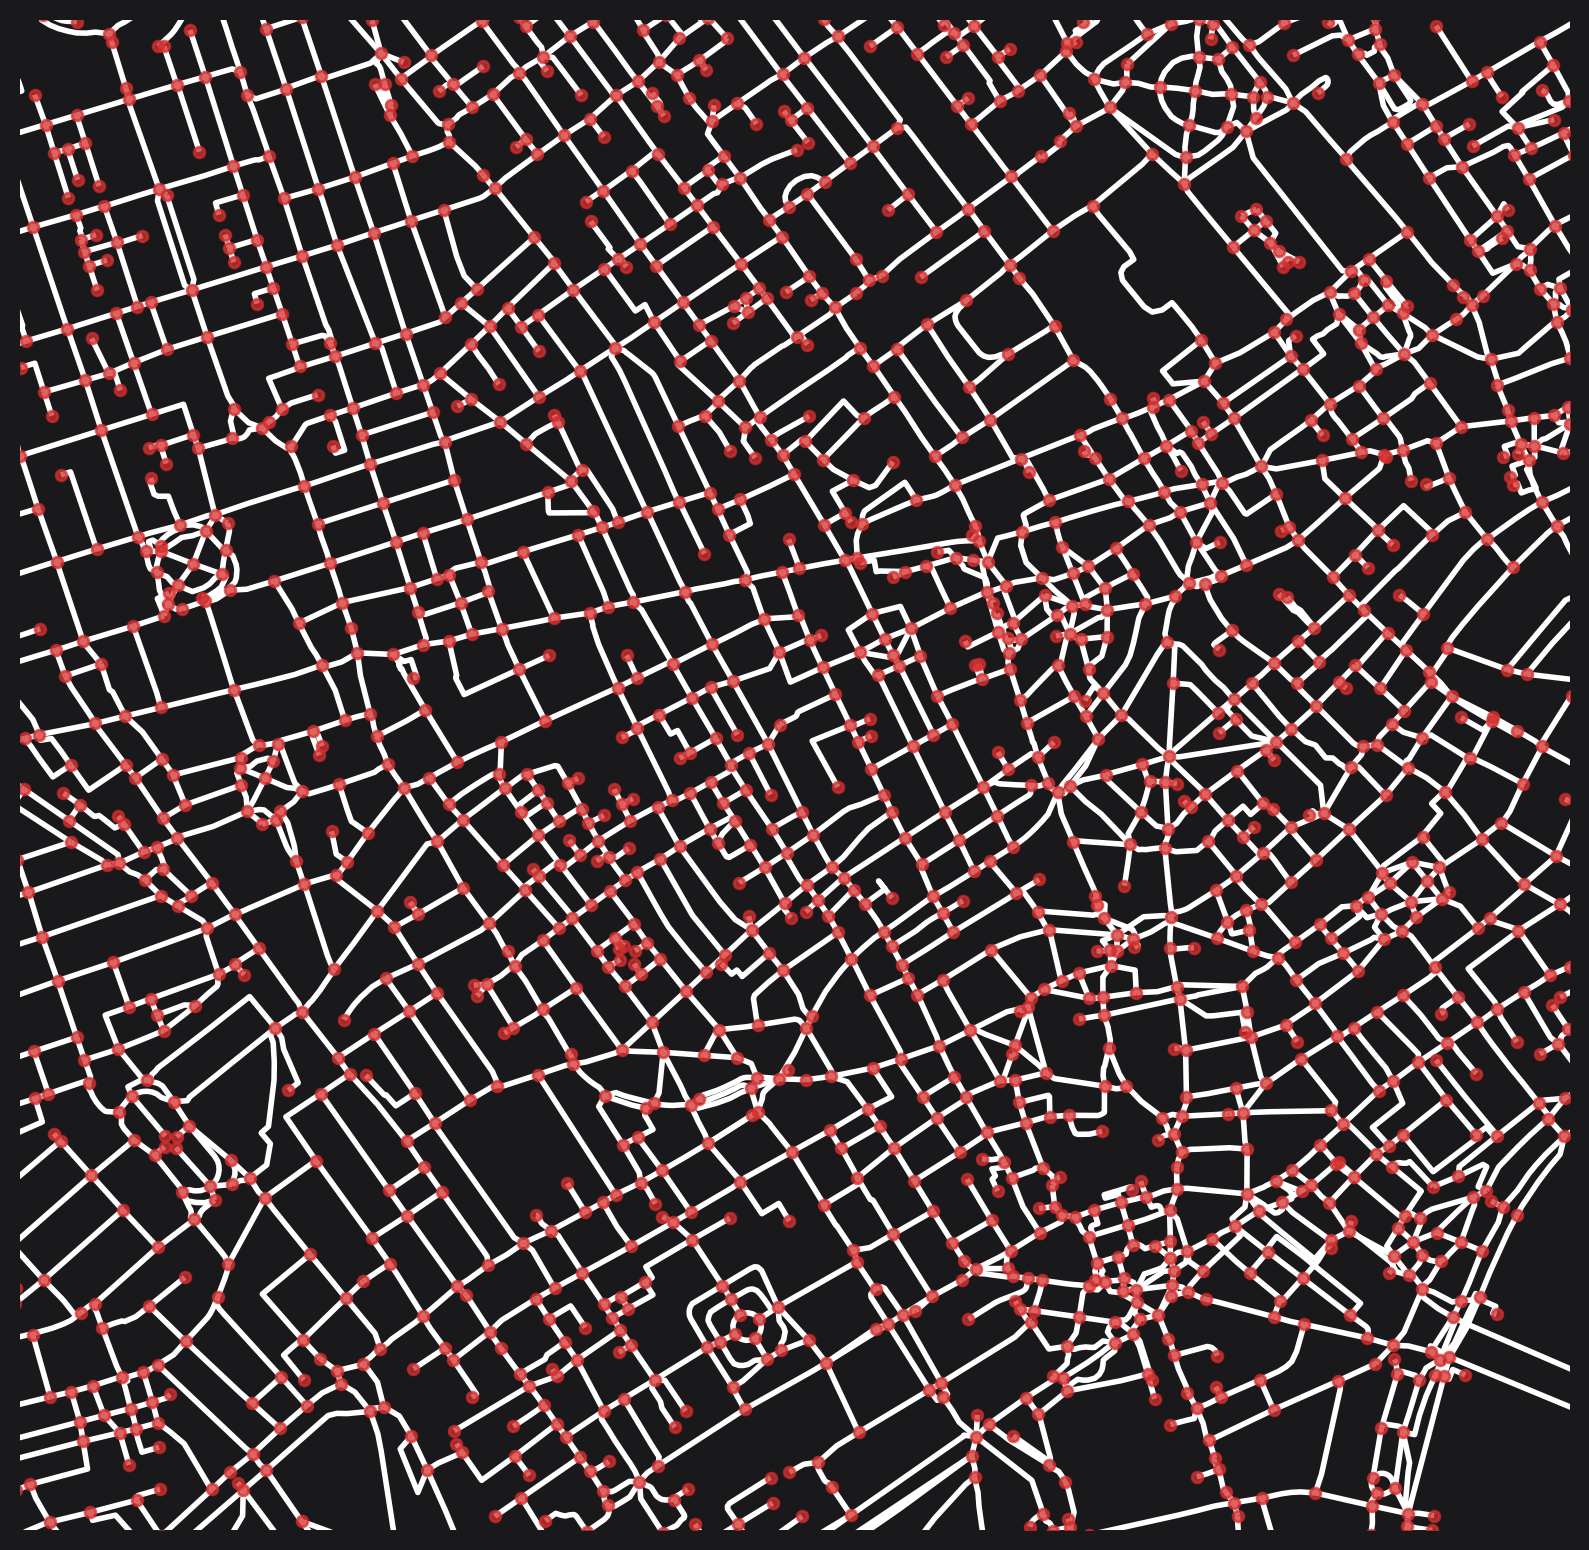

In [4]:
# WORKFLOW 2: Using cityseer to prepare the graph
# ===============================================
# let's convert the OSMnx graph to a cityseer compatible `multiGraph`
G_raw = tools.graphs.nx_from_osm_nx(multi_di_graph_raw)
# convert to UTM
G = tools.graphs.nx_wgs_to_utm(G_raw)
# infer geoms
G = tools.graphs.nx_simple_geoms(G)
# remove degree=2 nodes
G = tools.graphs.nx_remove_filler_nodes(G)
# remove dangling nodes
G = tools.graphs.nx_remove_dangling_nodes(G, despine=10)
# repeat degree=2 removal to remove orphaned nodes due to despining
G = tools.graphs.nx_remove_filler_nodes(G)
# let's consolidate the nodes
G1 = tools.graphs.nx_consolidate_nodes(G, buffer_dist=10, min_node_group=3)
# and we'll try to remove as many parallel roadways as possible
G2 = tools.graphs.nx_split_opposing_geoms(G1, buffer_dist=15)
G3 = tools.graphs.nx_consolidate_nodes(G2, buffer_dist=15, crawl=False, min_node_degree=2, cent_min_degree=4)
simple_plot(G3)